# Sellers Data Analysis

**Notebook Objective**

While our [analysis of the **Orders** dataset](./Orders%20Analysis.ipynb) from Brazilian e-commerce platform **Olist** revealed that `wait_time` was one of the more significant factors in explaining review scores, the low R-squared in our regression models suggested that there were other factors to consider outside of the **Orders** data.

In this notebook we'll use the **Sellers** dataset from **Olist** to see if we can identify features that influence review scores when grouping by individual sellers. In the first three sections, we'll do some exploratory data analysis by inspecting features, examining distributions, and then looking for any correlations. Next, we'll apply both linear and logistic regression models to better understand the relationship between specific features and the `seller_review_score`.

***Exploratory Data Analysis***

1. Inspect Features
2. Distributions
2. Correlations

***Models***

3. Multivariate Regression
4. Logistic Regression




If bad reviews are indeed linked to particular sellers, we'll be able to identify them and try to understand the reasons for poor performance. 

In [1]:
# Import relevant libraries and modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import math
import paths

from olist.seller import Seller

## Inspect Features

In [2]:
# Load and inspect Sellers data
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,seller_wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,seller_review_score,review_cost_per_seller,n_orders,quantity,quantity_per_order,sales
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99


In [3]:
# Inspect data types and check for null values
sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2970 entries, 0 to 2969
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   seller_id               2970 non-null   object        
 1   seller_city             2970 non-null   object        
 2   seller_state            2970 non-null   object        
 3   delay_to_carrier        2970 non-null   float64       
 4   seller_wait_time        2970 non-null   float64       
 5   date_first_sale         2970 non-null   datetime64[ns]
 6   date_last_sale          2970 non-null   datetime64[ns]
 7   months_on_olist         2970 non-null   float64       
 8   share_of_one_stars      2970 non-null   float64       
 9   share_of_five_stars     2970 non-null   float64       
 10  seller_review_score     2970 non-null   float64       
 11  review_cost_per_seller  2970 non-null   int64         
 12  n_orders                2970 non-null   int64   

## Distributions

Let's begin by analyzing features from the **Sellers** dataset and understanding their distributions. We'll examine them in smaller groups:
- `delay_to_carrier`, `seller_wait_time`
- `n_orders`, `quantity`, `quantity_per_order`, `sales`, and `months_on_olist`
- `seller_review_score`, `share_of_one_stars`, and `share_of_five_stars`

### Distributions for `delay_to_carrier`, `seller_wait_time`

This pair of features relates to the time associated with order fulfillment and is calculated per seller.

- `delay_to_carrier`: represents the average delay (in days) by a seller for delivering an order to the carrier.

- `seller_wait_time`: represents the average `wait_time` (in days), starting from the customer placing an order online to receiving delivery of that order. 
(**Note:** This differs from the `wait_time` variable in the **Orders** dataset in that it's been calculated as the *average `wait_time` for each seller).* 



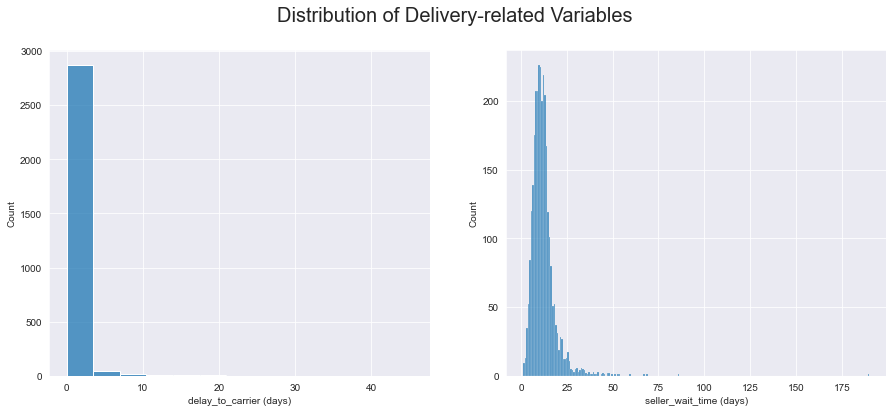

In [4]:
# Distributions of delivery-related variables
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
fig.suptitle('Distribution of Delivery-related Variables', fontsize=20)

# 'delay_to_carrier' histogram
ax1 = plt.subplot(121)
ax1 = sns.histplot(sellers.delay_to_carrier)
plt.xlabel('delay_to_carrier (days)')

# 'seller_wait_time' histogram
ax2 = plt.subplot(122)
ax2 = sns.histplot(sellers.seller_wait_time)
plt.xlabel('seller_wait_time (days)')

plt.show(); 

There are some outliers here that skew the distribution plot, so let's also check out the summary stats. 

In [5]:
# Summary stats
sellers[['delay_to_carrier','seller_wait_time']].describe()

,delay_to_carrier,seller_wait_time
count,2970.000000,2970.000000
mean,0.402786,12.160414
std,2.391687,7.103208
min,0.000000,1.214178
25%,0.000000,8.289263
50%,0.000000,11.120969
75%,0.000000,14.240673
max,45.434039,189.863160


In [6]:
# Percentage of sellers who have ever been part of a delayed order
round(sellers[sellers.delay_to_carrier > 1]['delay_to_carrier'].count() / len(sellers) * 100, 2)

5.72

From our plot we can see that very few sellers have contributed to delays in an order. Further calculations show that indeed only **5.72%** of sellers have ever been part of a delayed order, so there are likely other reasons associated with low review scores in addition to `delay_to_carrier`. 

While the plot for `seller_wait_time` is right-skewed, this appears to be the effect of only a few outliers since the mean is still close to the median. This indicates that most sellers are still clustered tightly around the center and that there are not enough sellers with longer average wait times to pull the mean further to the right.  

### Distributions for `n_orders`, `quantity`, `quantity_per_order`, `sales`, `months_on_olist`

These features indicate the various quantities related to orders on a per seller basis:  

- `n_orders`: the total number of orders a seller has had while on the platform
- `quantity`: the total number of items that have been sold by a seller
- `quantity_per_order`: lifelong average per seller derived from dividing `n_orders` by `quantity`
- `sales`: the total sales (in BRL) each seller has made to date

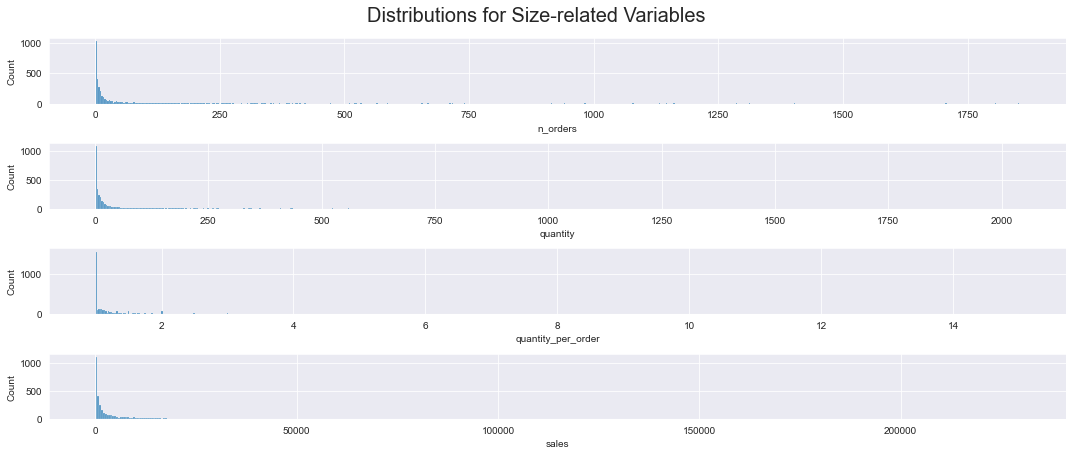

In [7]:
# Distributions for size-related variables
fig, (ax1, ax2, ax3, ax2) = plt.subplots(4,1)
plt.figure(figsize=(15,6)).suptitle('Distributions for Size-related Variables', fontsize=20)
plt.close(1)

#'n_orders'
ax1 = plt.subplot(411)
ax1 = sns.histplot(sellers.n_orders)
plt.tight_layout()

#'quantity'
ax2 = plt.subplot(412)
ax2 = sns.histplot(sellers.quantity)

#'quantity_per_order'
ax3 = plt.subplot(413)
ax3 = sns.histplot(sellers.quantity_per_order)

#'sales'
ax3 = plt.subplot(414)
ax3 = sns.histplot(sellers.sales)

plt.show();

The outliers are quite extreme with these features making the plots difficult to read. We'll re-plot them with an adjusted view that excludes outliers.

In [8]:
sellers[['n_orders', 'quantity', 'quantity_per_order', 'sales']].describe()

,n_orders,quantity,quantity_per_order,sales
count,2970.000000,2970.000000,2970.000000,2970.000000
mean,33.617508,38.085185,1.162150,4566.515906
std,107.133714,122.417269,0.443348,14185.211617
min,1.000000,1.000000,1.000000,6.500000
25%,2.000000,3.000000,1.000000,239.800000
50%,7.000000,8.000000,1.000000,893.500000
75%,23.000000,26.000000,1.152009,3586.022500
max,1854.000000,2039.000000,15.000000,229472.630000


In [9]:
# Outlier calculations (based on 1.5*IQR)

features = ['n_orders', 'quantity', 'quantity_per_order', 'sales']

max_xlim = []
q3_xlim = []

for f in features:
    q3 = np.quantile(sellers[f], .75, axis=0) 
    q1 = np.quantile(sellers[f], .25, axis=0) 
    iqr = q3-q1 
    outlier_x = 1.5*iqr
    max_xlim.append(outlier_x)
    q3_xlim.append(q3)

max_xlim

[31.5, 34.5, 0.22801383399209474, 5019.33375]

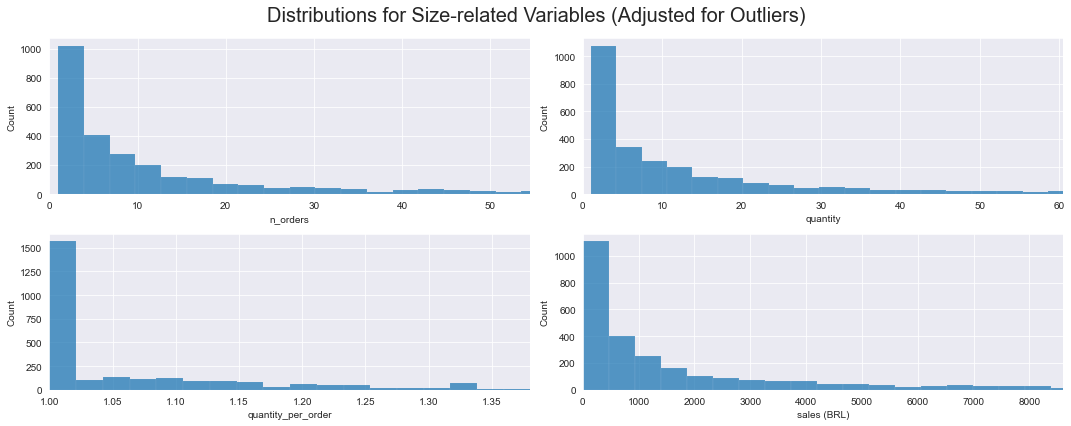

In [10]:
# Re-plotting features with an adjusted view to exclude outliers
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
plt.figure(figsize=(15,6)).suptitle('Distributions for Size-related Variables (Adjusted for Outliers)', fontsize=20)
plt.close(1)

# 'n_orders'
ax1 = plt.subplot(221)
ax1 = sns.histplot(sellers.n_orders)
ax1.set_xlim(0, q3_xlim[0] + max_xlim[0])

# 'quantity'
ax2 = plt.subplot(222)
ax2 = sns.histplot(sellers.quantity)
ax2.set_xlim(0, q3_xlim[1] + max_xlim[1])

# 'quantity_per_order'
ax3 = plt.subplot(223)
ax3 = sns.histplot(sellers.quantity_per_order)
ax3.set_xlim(1, q3_xlim[2] + max_xlim[2])

# 'sales'
ax4 = plt.subplot(224)
ax4 = sns.histplot(sellers.sales)
ax4.set_xlabel('sales (BRL)')
ax4.set_xlim(0, q3_xlim[3] + max_xlim[3])

plt.tight_layout()
plt.show();

Since both `n_orders` and `quantity` speak to the volume of product that sellers have sold, it's not surprising that their distribution is similar. 

If we consider that seller experience with processing orders has an impact on review scores, `n_orders` might be one feature that can capture some to of this. With median `n_orders` of only **7**, it appears most sellers on the platform have not had a large number of transactions.
 
The distribution of `quantity_per_order` indicates that on average most orders only have a single item. If we had seen on average more multiple-item orders, order mix-ups could have been a large factor in low review scores, but here we only see a low occurrence of multiple-item orders.  

The total `sales` per seller seems to follow a similar distribution with these other features—skewed to the right, but with the bulk of data points still near low values. Half of all sellers have generated less than **893.50 BRL** (~170 USD) in total sales.

Another feature that might speak more directly to seller experience is `months_on_olist`, which tells how long a seller has been on the platform.

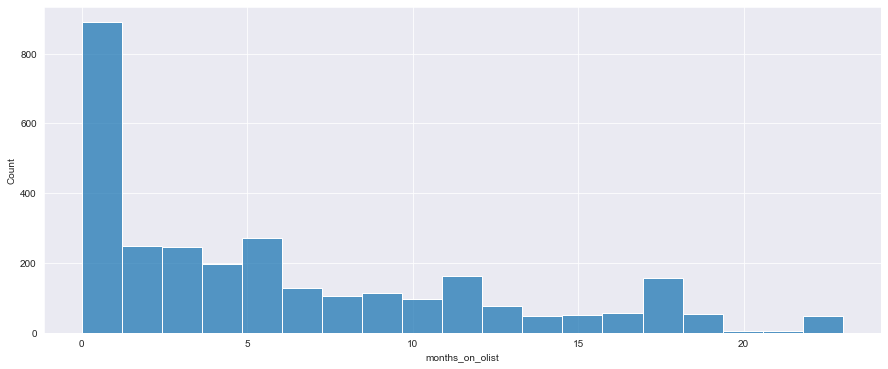

In [11]:
# 'months_on_olist' histogram
plt.figure(figsize=(15,6))
sns.histplot(sellers.months_on_olist)
plt.show()           

In [12]:
# Summary stats 
sellers[['months_on_olist']].describe()

,months_on_olist
count,2970.000000
mean,6.019529
std,5.994240
min,0.000000
25%,1.000000
50%,4.000000
75%,10.000000
max,23.000000


As Olist is a fairly new platform, we can see that the oldest sellers have only been using it for **23 months**. Additionally, half of all sellers have been using the platform for **4 months or less**. 

### Distribution of `seller_review_score`, `share_of_one_stars`, `share_of_five_stars`

These features indicate how sellers have been performing based on customer feedback.   

- `seller_review_score`: the average score of a seller's reviews 
- `share_of_one_stars`: the proportion of a seller's reviews with only one star 
- `share_of_five_stars`: the proportion of a seller's reviews with five stars


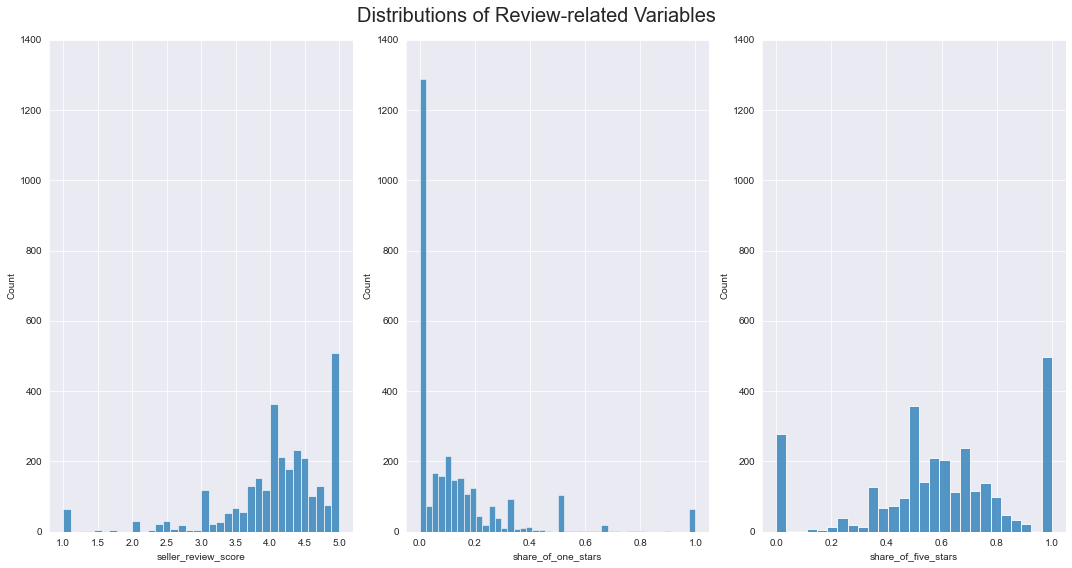

In [13]:
# Distributions of review-related variables
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
plt.close(1)
plt.figure(figsize=(15,8)).suptitle('Distributions of Review-related Variables', fontsize=20)

# 'seller_review_score' histogram
ax1 = plt.subplot(131)
ax1 = sns.histplot(sellers.seller_review_score)
ax1.set_ylim(0,1400)

# 'share_of_one_stars' histogram
ax2 = plt.subplot(132)
ax2 = sns.histplot(sellers.share_of_one_stars)
ax2.set_ylim(0,1400)

# 'share_of_five_stars' histogram
ax3 = plt.subplot(133)
ax3 = sns.histplot(sellers.share_of_five_stars)
ax3.set_ylim(0,1400)

plt.tight_layout()
plt.show();

In [14]:
sellers[['seller_review_score', 'share_of_one_stars', 'share_of_five_stars']].describe()

,seller_review_score,share_of_one_stars,share_of_five_stars
count,2970.000000,2970.000000,2970.000000
mean,4.086880,0.124570,0.592130
std,0.810166,0.191870,0.279057
min,1.000000,0.000000,0.000000
25%,3.818424,0.000000,0.478261
50%,4.200000,0.063856,0.600000
75%,4.625000,0.166667,0.750000
max,5.000000,1.000000,1.000000


From our plots and statistical summary, we can see that the average `seller_review_score` is **close to 4** (mean = 4.087), while those receiving an average score of **3.8 or less** already fall into the **bottom 25%** of seller performance (Q1 = 3.82). This reflects a **J-shaped distribution** which is a common phenomenon found among online reviews and discussed earlier in more detail in our **[Orders Data Analysis.](./Orders%20Analysis.ipynb)**

In [15]:
# Percentage of sellers who have never received a 1-star rating
round(sellers[sellers.share_of_one_stars == 0]['share_of_one_stars'].count() / len(sellers) * 100, 2)

42.93

Our plot and stat summary of `share_of_one_stars` indicate that for **75% of sellers** on the platform, a 1-star rating comprises only **a sixth or less** of their total reviews (Q3 = 0.167). From further calculations, we also see that **43%** of sellers have **never received** a 1-star rating. 

With the feature `share_of_five_stars` we see a **W-shaped distribution** with three peaks. On **the far right**, there is a large number of *'super-performers'* who have only received 5-star reviews. Next, we have two smaller peaks occurring at a) **the center**, where on average only half of their reviews received a 5-star review, and b) **the far left**, where a substantial number have never gotten 5 stars. 

For a fairer assessment that takes into consideration the total number of reviews each seller has received, we might also explore assigning weights to each 1-star (or 5-star review) that are proportional to the total number of reviews received (i.e., we could control that a seller with a hundred 5-star reviews and a single 1-star review would still rank higher than a seller with only ten reviews but all of which are 5-star).        

## Correlations

Let's check out the correlations between different features in the **Sellers** dataset.

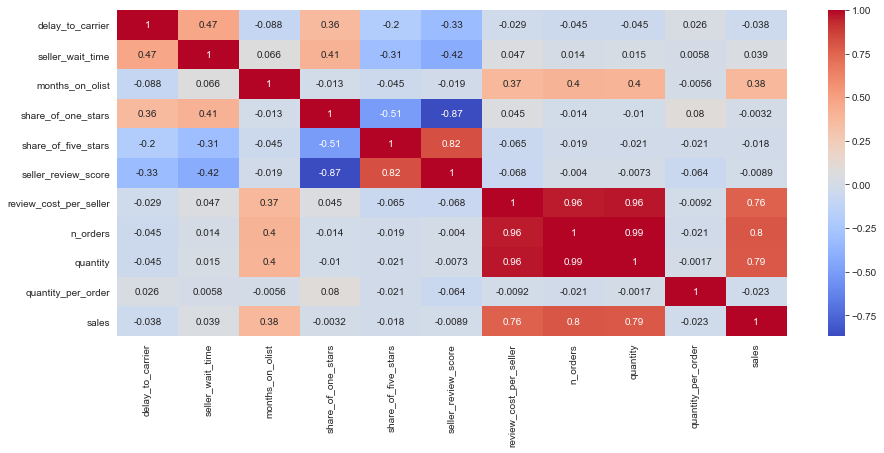

In [16]:
# Use heatmap to see correlations between features and target variables
plt.figure(figsize=(15,6))
sns.heatmap(sellers.corr(), cmap='coolwarm', annot=True );

In [17]:
# Isolated view of correlation coefficients with target variable `seller_review_score`
sellers.corr()['seller_review_score']

delay_to_carrier         -0.325642
seller_wait_time         -0.419605
months_on_olist          -0.018910
share_of_one_stars       -0.869186
share_of_five_stars       0.818685
seller_review_score       1.000000
review_cost_per_seller   -0.067521
n_orders                 -0.003983
quantity                 -0.007311
quantity_per_order       -0.064025
sales                    -0.008910
Name: seller_review_score, dtype: float64

Among features that aren't derived from `seller_review_score`, those that capture delivery time such as `delay_to_carrier` (r = -0.33) and `seller_wait_time` (r = -0.42) have the largest correlation with `seller_review_score`.

Not surprisingly, there is high correlation between features that are in similar groupings such as `n_orders` and `quantity` (r = 0.99). Let's check for collinearity by calculating the ***variable inflation factor (VIF)*** for each of our selected features.

### Check for Multicollinearity with VIF

Collinearity occurs when features (independent variables) have a high linear correlation. This creates an issue with  regression models by making their coefficients and p-values less reliable. 

To detect if there is multicollinearity (collinearity with more than 2 features), we can calculate each feature's **variable inflation factor (VIF)**, which tells us *how much* variance for a regression coefficient is inflated due to collinearity.

$ VIF = \frac {1}{1 - R^2} $

An VIF value of **1** indicates *no correlation*, **1 - 5** is *moderate correlated*, and **> 5** is *highly correlated*. However, values **less than 10** are generally considered acceptable levels of correlation within your features.   

In [18]:
# Calculate Variable Inflation Factor (VIF)
features = ['delay_to_carrier', 'seller_wait_time', 'months_on_olist', 'n_orders', 'quantity',  'quantity_per_order', 'sales']

X = sellers[features]
df = pd.DataFrame()
df['VIF'] = [vif(X.values, i) for i in range(X.shape[1])]
df['Features'] = X.columns
df

,VIF,Features
0,1.298334,delay_to_carrier
1,3.841865,seller_wait_time
2,2.358235,months_on_olist
3,85.648334,n_orders
4,83.633394,quantity
5,3.384106,quantity_per_order
6,3.089553,sales


We see here that the features `n_orders` and `quantity` have high VIF values. We'll remove `quantity` from our list because it has slightly higher correlations with other features when compared to `n_orders`. 

Let's now recalculate our VIF values.

In [19]:
# Remove `quantity` from features list
features = ['delay_to_carrier', 'seller_wait_time', 'months_on_olist', 'n_orders',  'quantity_per_order', 'sales']

X = sellers[features]
df = pd.DataFrame()
df['VIF'] = [vif(X.values, i) for i in range(X.shape[1])]
df['Features'] = X.columns
df

,VIF,Features
0,1.297873,delay_to_carrier
1,3.826915,seller_wait_time
2,2.352849,months_on_olist
3,3.147314,n_orders
4,3.347037,quantity_per_order
5,3.088835,sales


We now have more acceptable VIF values for our features.

## Multivariate Regression  

In this section, we'll build multivariate regression models to better understand what features from our **Sellers** dataset influence `seller_review_score`. 

### Feature Scaling

To make sure we'll be able to compare the coefficients for features that have different units, we'll first do some feature scaling. Since many of our features have outliers, we'll choose **standardization** over normalization
since *standardization* is more robust against outliers. 

In [20]:
# Define standardization function
def standardize(df, features): 
    df_standardized = df.copy()
    for f in features:
        mu = df[f].mean()
        sigma = df[f].std()
        df_standardized[f] = df[f].map(lambda x: (x - mu) / sigma)
    return df_standardized

### Linear Regression | Base Model

Using our current features list, let's standardize and then run a linear regression model to determine how much each feature impacts `seller_review_score`.

In [21]:
# Standardize features and run linear regression model
sellers_standardized = standardize(sellers, features)
model = smf.ols(formula=f"seller_review_score ~ {'+ '.join(features)}", data=sellers_standardized).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     seller_review_score   R-squared:                       0.200
Model:                             OLS   Adj. R-squared:                  0.199
Method:                  Least Squares   F-statistic:                     123.8
Date:                 Sat, 25 Sep 2021   Prob (F-statistic):          4.78e-140
Time:                         22:14:39   Log-Likelihood:                -3256.2
No. Observations:                 2970   AIC:                             6526.
Df Residuals:                     2963   BIC:                             6568.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0869      0.013    307.146      0.000       4.061       4.113
delay_to_carrier      -0.1328      0.015     -8.712      0.000      -0.163      -0.103
seller_wait_time      -0.2766      0.015    -18.164      0.000      -0.306      -0.247
months_on_olist       -0.0083      0.015     -0.563      0.574      -0.037       0.021
n_orders              -0.0099      0.023     -0.441      0.659      -0.054       0.034
quantity_per_order    -0.0469      0.013     -3.518      0.000      -0.073      -0.021
sales                  0.0086      0.022      0.386      0.700      -0.035       0.052
==============================================================================
Omnibus:                      813.497   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2772.679
Skew:                          -1.350   Prob(JB):                         0.00
Kurtosis:                       6.887   Cond. No.                         3.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

- This model has a **low R-squared** (R2 = 0.20) suggesting that the currently selected features only explain **20% of the variance** found in the `seller_review_score`. Also, the lower value for **Adj. R-squared** (Adj. R2 = 0.199) suggests that we may have extra features in our model that are contributing more to noise than to understanding the key factors influencing our target variable. 
- The coefficients for the features `months_on_olist`, `n_orders`, and `sales` are **not statistically significant** as their **p-values** do **not fall below our chosen alpha of 0.05**. 
- Additionally, we see that a value of 0 falls within the **95% confidence interval** for these features. Since a zero coefficient would mean that the feature has no influence on the target variable (i.e., our null hypothesis), this would mean we can't reject the null hypothesis and that that the given **coefficients** for these features are **not reliable**. 

Since the p-values for features `months_on_olist`, `n_orders`, and `sales` are not **statistically significant**, we'll remove them from our features list, and run another regression.

### Linear Regression | Revised Model

In [22]:
# Revised feature selection
revised_features = ['delay_to_carrier', 'seller_wait_time', 'quantity_per_order']
sellers_standardized = standardize(sellers, revised_features)
revised_model = smf.ols(formula=f"seller_review_score ~ {'+ '.join(revised_features)}", data=sellers_standardized).fit()

In [23]:
revised_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     seller_review_score   R-squared:                       0.200
Model:                             OLS   Adj. R-squared:                  0.200
Method:                  Least Squares   F-statistic:                     247.7
Date:                 Sat, 25 Sep 2021   Prob (F-statistic):          2.08e-143
Time:                         22:14:39   Log-Likelihood:                -3256.6
No. Observations:                 2970   AIC:                             6521.
Df Residuals:                     2966   BIC:                             6545.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.0869      0.013    307.268      0.000       4.061       4.113
delay_to_carrier      -0.1315      0.015     -8.710      0.000      -0.161      -0.102
seller_wait_time      -0.2776      0.015    -18.391      0.000      -0.307      -0.248
quantity_per_order    -0.0468      0.013     -3.519      0.000      -0.073      -0.021
==============================================================================
Omnibus:                      797.448   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2693.675
Skew:                          -1.326   Prob(JB):                         0.00
Kurtosis:                       6.838   Cond. No.                         1.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

- With this reduced set of features, our model is still only able to explain about **20% of the variance** in the seller review scores (R2 = 0.20). 
- Among our **Sellers** data, a seller's average wait time appears to have the most influence on his or her average review score. *Holding all other variables constant, for every added day in `seller_wait_time`, the `seller_review_score` on average **decreases by 28%** (slope = -0.02776).* 
- While we already saw that only about 6% of sellers contributed to a delayed order, our regression model indicates that for those that have, they *on average experience a **13% decrease** in `seller_review_score` for each additional day of delay, holding all other variables constant (slope = -0.1315).*  
- Similarly, we saw that most sellers do not sell more than 1 item per order. However, our regression shows that *if the average item per order increases by a whole item, on average we see a **decrease** in `seller_review_score` by **5%**, holding all other variables constant (slope = -0.0468).*     

Let's plot the coefficients to more easily compare them to each other. 

In [24]:
revised_model.params

Intercept             4.086880
delay_to_carrier     -0.131504
seller_wait_time     -0.277566
quantity_per_order   -0.046824
dtype: float64

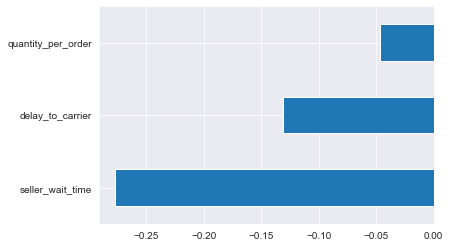

In [25]:
revised_model.params[1:].sort_values().plot(kind='barh');

### Residuals and RMSE

Now let's look at the **residuals** (predicted values - real values) and calculate the **Root Mean Square Error (RMSE)** as a check to see how well our multivariate regression model is performing. 

In [26]:
# Calculate residuals (predicted values - real values)
predicted_review_score = revised_model.predict(sellers_standardized[features])
residuals = predicted_review_score - sellers_standardized.seller_review_score
residuals.head()

0    1.092618
1   -0.305559
2   -0.556623
3   -0.620117
4    2.036966
dtype: float64

In [27]:
# Calculate the RMSE
RMSE = (residuals.map(lambda x: x**2).sum() / len(residuals))**0.5
RMSE

0.7243697584549219

The **RMSE** tells us that on average our predicted scores are **0.7** stars off of the real scores. On a 5-star rating system, that's not too bad. 

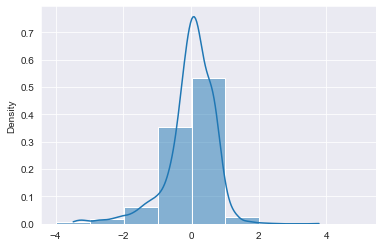

In [28]:
# Residual density plot
sns.histplot(model.resid, kde=True, stat='density', discrete=True);

 ## Logistic Regression

Since the `seller_review_score` is calculated as an average for each seller, we can get a continuous target variable ranging from 0-5 stars. This differs from the **Orders** dataset feature of `review_score` which could be understood as a ordinal categorical variable. This perhaps explains why we have a slightly better **R-squared of = 0.20** for our **Sellers Linear Regression** compared to the one from our **Orders Linear Regression (R2 = 0.14)**.

Like we did for the **Orders** dataset, let's try running logistic regression models for both **1-star** (`share_of_one_stars`) and **5-star** (`share_of_five_stars`) **reviews**, but now for our **Sellers** dataset.

### Logistic Regression | 1-Star Review Model

Let's run our logistic regression model for 1-star reviews  

In [29]:
#Fit logit model for 1-star reviews
sellers_standardized = standardize(sellers, revised_features)
logit_one = smf.logit(formula=f"share_of_one_stars ~ {'+ '.join(revised_features)}", data=sellers_standardized).fit()
logit_one.summary()

Optimization terminated successfully.
         Current function value: 0.232556
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     share_of_one_stars   No. Observations:                 2970
Model:                          Logit   Df Residuals:                     2966
Method:                           MLE   Df Model:                            3
Date:                Sat, 25 Sep 2021   Pseudo R-squ.:                 -0.2908
Time:                        22:14:41   Log-Likelihood:                -690.69
converged:                       True   LL-Null:                       -535.09
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.0497      0.060    -34.373      0.000      -2.167      -1.933
delay_to_carrier       0.1927      0.063      3.071      0.002       0.070       0.316
seller_wait_time       0.5206      0.066      7.943      0.000       0.392       0.649
quantity_per_order     0.0971      0.048      2.036      0.042       0.004       0.191
======================================================================================
"""

To better interpret the coefficients from our logistic regression model, we'll convert units from log-odds (logits) to odds. 

In [30]:
# Log-odds to odds conversion by exponentiating
logit_one_results = pd.DataFrame(logit_one.params, columns=['log-odds'])
logit_one_results['odds'] = logit_one_results['log-odds'].apply(lambda x: math.exp(x))
logit_one_results

,log-odds,odds
Intercept,-2.049681,0.128776
delay_to_carrier,0.192672,1.212484
seller_wait_time,0.520643,1.683109
quantity_per_order,0.097100,1.101970


**Interpretation of Results**

- All of our coefficients are **statistically significant** given our **p-values** are below our alpha of 0.05. However, we note that the feature `quantity_per_order` is quite close to the threshold (p-value = 0.042) 

- With our model, we see that `seller_wait_time` has the most influence on receiving a 1-star review. *Holding all other variables constant, for each additional day in `seller_wait_time`, on average there is a **68% increase in odds** of getting a 1-star review*.

### Logistic Regression | 5-Star Review Model

Now let's run another logistic regression model for 5-star reviews.  

In [31]:
# Fit logit model for 5-star reviews
sellers_standardized = standardize(sellers, revised_features)
logit_five = smf.logit(formula=f"share_of_five_stars ~ {'+ '.join(revised_features)}", data=sellers_standardized).fit()
logit_five.summary()

Optimization terminated successfully.
         Current function value: 0.636639
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     share_of_five_stars   No. Observations:                 2970
Model:                           Logit   Df Residuals:                     2966
Method:                            MLE   Df Model:                            3
Date:                 Sat, 25 Sep 2021   Pseudo R-squ.:                0.008160
Time:                         22:14:41   Log-Likelihood:                -1890.8
converged:                        True   LL-Null:                       -1906.4
Covariance Type:             nonrobust   LLR p-value:                 8.045e-07
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3676      0.038      9.622      0.000       0.293       0.442
delay_to_carrier      -0.1321      0.067     -1.982      0.047      -0.263      -0.001
seller_wait_time      -0.4206      0.054     -7.741      0.000      -0.527      -0.314
quantity_per_order    -0.0197      0.038     -0.519      0.604      -0.094       0.055
======================================================================================
"""

In [32]:
# Log-odds to odds conversion by exponentiating
logit_five_results = pd.DataFrame(logit_five.params, columns=['log-odds'])
logit_five_results['odds'] = logit_five_results['log-odds'].apply(lambda x: math.exp(x))
logit_five_results

,log-odds,odds
Intercept,0.367579,1.444234
delay_to_carrier,-0.132075,0.876275
seller_wait_time,-0.420552,0.656684
quantity_per_order,-0.019682,0.980510


**Interpretation of Results**

- In this model, our feature `quantity_per_order` is **not statistically significant** (p-value = 0.60), so we cannot reject the null hypothesis that `quantity_per_order` has no impact on receiving a 5-star score. 

- While the coefficients for our other two features are **statistically significant**, we note that the p-value for `delay_to_carrier` (p-value = 0.047) is close to our alpha threshold of 0.05.  

- With this model, we also see `seller_wait_time` as having the largest influence on the star rating. *Holding all other variables constant, for each additional day in `seller_wait_time`, on average there is a **34% decrease in odds** of getting a 5-star review.*

### Logistic Regression Model Comparison

/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


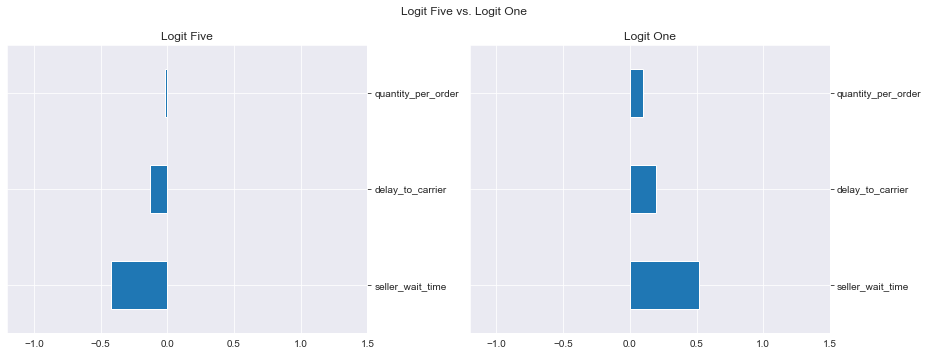

In [33]:
# Logistic Regression Model Comparison
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
fig.suptitle('Logit Five vs. Logit One')

# Logistic Regression - logit_five_model
ax1 = plt.subplot(1,2,1)
ax1.set_title('Logit Five')
ax1.yaxis.tick_right()
ax1.set_xlim(-1.2, 1.5)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax1)

# Logistic Regression - logit_one_model
ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit One')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.2, 1.5)
logit_one.params[1:].sort_values(ascending=False).plot(kind='barh', ax=ax2)

plt.tight_layout()
plt.show();

Both logistic regression models seem to point to `seller_wait_time` as the most influential feature in receiving a 1- or 5-star review.  

### Linear vs Logistic Regression Coefficients

Let's plot and compare the coefficients of both our linear regression and logistic regression models to see if they are generally telling the same story. 

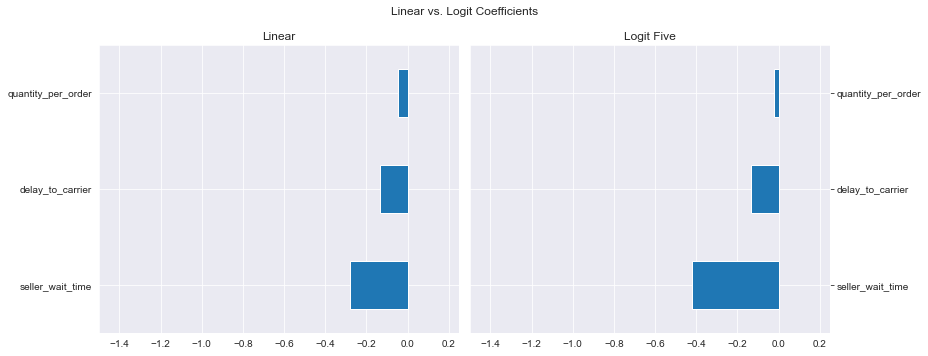

In [34]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficients')

# Linear Regression - Revised Model
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-1.5, 0.25)
revised_model.params[1:].sort_values().plot(kind='barh', ax=ax1)

# Logistic Regression - logit_five_model
ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit Five')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2)

plt.tight_layout()
plt.show()

While we cannot directly compare the values of the coefficients from our linear and logistic regression models, we can see that they show *similar feature importance.* In both models, `seller_wait_time` appears to have the the largest association with `seller_wait_time` followed by `delay_to_carrier`. It appears that delivery duration has a large influence on review scores.  